## i. Latar Belakang
Analisis "Review of Shipping and Stock Performance in Q1 - Q2 2023" dilakukan untuk mengevaluasi waktu pengiriman rata-rata, mengidentifikasi penyebab keterlambatan pengiriman, menghitung jumlah stok, dan menganalisis hubungannya dengan penjualan. Tujuan utamanya adalah untuk meningkatkan efisiensi operasional, memenuhi kebutuhan pelanggan, dan mengoptimalkan manajemen rantai pasokan perusahaan. Analisis ini memberikan wawasan penting dalam usaha untuk meningkatkan pelayanan pelanggan dan manajemen persediaan.

## ii. Objektif

Analisis Kinerja Pengiriman (Shipping Performance Analysis):

* Evaluasi waktu pengiriman rata-rata dari tanggal pemesanan hingga tanggal pengiriman selama kuartal pertama hingga kuartal kedua 2023. Memeriksa apakah terdapat perubahan dalam waktu pengiriman selama periode ini.
* Penentuan penyebab keterlambatan pengiriman.

Analisis Kinerja Stok (Stock Performance Analysis):

* Perhitungan jumlah produk yang tersedia (stok) selama kuartal pertama hingga kuartal kedua 2023.
* Evaluasi perubahan stok dari waktu ke waktu dan hubungannya dengan tingkat penjualan. Apakah terdapat tren penjualan khusus yang berdampak pada stok?

Hubungan antara Pengiriman dan Stok:

* Pertimbangan apakah terdapat hubungan antara waktu pengiriman dan ketersediaan stok. Sebagai contoh, apakah keterlambatan pengiriman berkaitan dengan ketidakcukupan stok?

## Query SQL

SELECT DISTINCT
id,
inventory_in_date,
inventory_out_date,
product_category,
product_name,
product_brand,
product_department,
status,
ordering_date,
shipping_date,
delivering_date,
returning_date,
sale_price,
age,
gender,
city,
country
FROM
(SELECT
ii.id,
DATE(ii.created_at) AS inventory_in_date,
DATE(ii.sold_at) AS inventory_out_date,
ii.product_category,
ii.product_name,
ii.product_brand,
ii.product_department,
oi.status,
DATE(oi.created_at) AS ordering_date,
DATE(oi.shipped_at) AS shipping_date,
DATE(oi.delivered_at) AS delivering_date,
DATE(oi.returned_at) AS returning_date,
oi.sale_price,
u.age,
u.gender,
u.city,
u.country
FROM `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii
JOIN `bigquery-public-data.thelook_ecommerce.order_items` AS oi
ON ii.id = oi.id
JOIN `bigquery-public-data.thelook_ecommerce.users` AS u
ON oi.id = u.id)
WHERE ordering_date BETWEEN '2023-01-01' AND '2023-06-30'
ORDER BY ordering_date

## Import Libraries

In [16]:
# Import Library yang digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as st
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data 
data = pd.read_csv(r'C:\Users\SatriyaFzn\Documents\Hactiv8\Projects\The_look\The_look_shipping.csv')


In [3]:
# Menampilkan data
data.head(5)

,id,inventory_in_date,inventory_out_date,product_category,product_name,product_brand,product_department,status,ordering_date,shipping_date,delivering_date,returning_date,sale_price,age,gender,city,country
0,46323,2023-06-21,NaN,Fashion Hoodies & Sweatshirts,DC Women's Impression Sweater,DC,Women,Processing,2023-01-01,NaN,NaN,NaN,88.949997,27,M,Funabashi City,Japan
1,6412,2021-07-14,NaN,Intimates,Bali Women's Powershape Lux Thigh Slimmer,Bali,Women,Complete,2023-01-01,2023-01-03,2023-01-04,NaN,165.000000,13,M,Murray,United States
2,31945,2021-04-18,NaN,Suits & Sport Coats,DKNY Mens 2 Button Flat Front Solid Light Brow...,DKNY,Men,Complete,2023-01-01,2023-01-03,2023-01-07,NaN,20.000000,22,F,El Centro,United States
3,32685,2023-09-06,2023-10-02,Fashion Hoodies & Sweatshirts,Roxy Juniors Blue Stream Kimono Sweater,Roxy,Women,Shipped,2023-01-01,2022-12-29,NaN,NaN,24.990000,24,F,Mönchengladbach,Germany
4,61713,2023-03-06,2023-03-26,Active,Zoot Sports Unisex Adult Crx Recovery Tight,Zoot,Men,Cancelled,2023-01-01,NaN,NaN,NaN,95.669998,20,M,Zhangzhou,China


In [4]:
# Merubah kolom tanggal ke data datetime
data['inventory_in_date'] = pd.to_datetime(data['inventory_in_date'])
data['inventory_out_date'] = pd.to_datetime(data['inventory_out_date'])
data['ordering_date'] = pd.to_datetime(data['ordering_date'])
data['shipping_date'] = pd.to_datetime(data['shipping_date'])
data['delivering_date'] = pd.to_datetime(data['delivering_date'])
data['returning_date'] = pd.to_datetime(data['returning_date'])

In [5]:
# Memfilter data yang digunakan
df = data.dropna(subset=['shipping_date'])
df = data[(data['inventory_in_date'] >= '2023-01-01') & (data['inventory_in_date'] <= '2023-06-30')]

## Problem 1

Analisis Kinerja Pengiriman (Shipping Performance Analysis):

* Evaluasi waktu pengiriman rata-rata dari tanggal pemesanan hingga tanggal pengiriman selama kuartal pertama hingga kuartal kedua 2023. Memeriksa apakah terdapat perubahan dalam waktu pengiriman selama periode ini.
* Penentuan penyebab keterlambatan pengiriman.

In [17]:
# Waktu pengiriman
df['delivery_time'] = df['shipping_date'] - df['ordering_date']

In [7]:
# Statistik deskriptif waktu pengiriman
df['delivery_time'].describe()

count                         2622
mean     0 days 10:46:24.439359267
std      1 days 17:00:14.646247486
min              -4 days +00:00:00
25%              -1 days +00:00:00
50%                1 days 00:00:00
75%                2 days 00:00:00
max                4 days 00:00:00
Name: delivery_time, dtype: object

Berdasarkan data yang diperoleh, waktu pengiriman rata-rata memiliki rentang sekitar ± 11 jam, dengan waktu pengiriman maksimum adalah 4 hari.

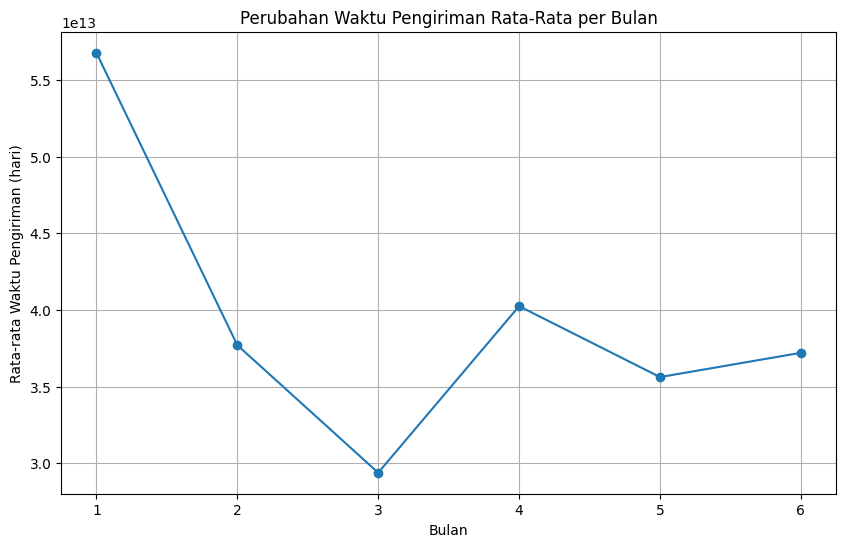

In [18]:
# visualisasi Perubahan Waktu Pengiriman Rata-Rata per Bulan
df['month'] = df['ordering_date'].dt.month
monthly_avg_delivery_time = df.groupby('month')['delivery_time'].mean()

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_delivery_time.index, monthly_avg_delivery_time.values, marker='o')
plt.title('Perubahan Waktu Pengiriman Rata-Rata per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata Waktu Pengiriman (hari)')
plt.grid(True)
plt.show()

Berdasarkan data, terlihat bahwa rata-rata waktu pengiriman pada bulan 1 lebih lama dibandingkan dengan bulan-bulan lainnya.

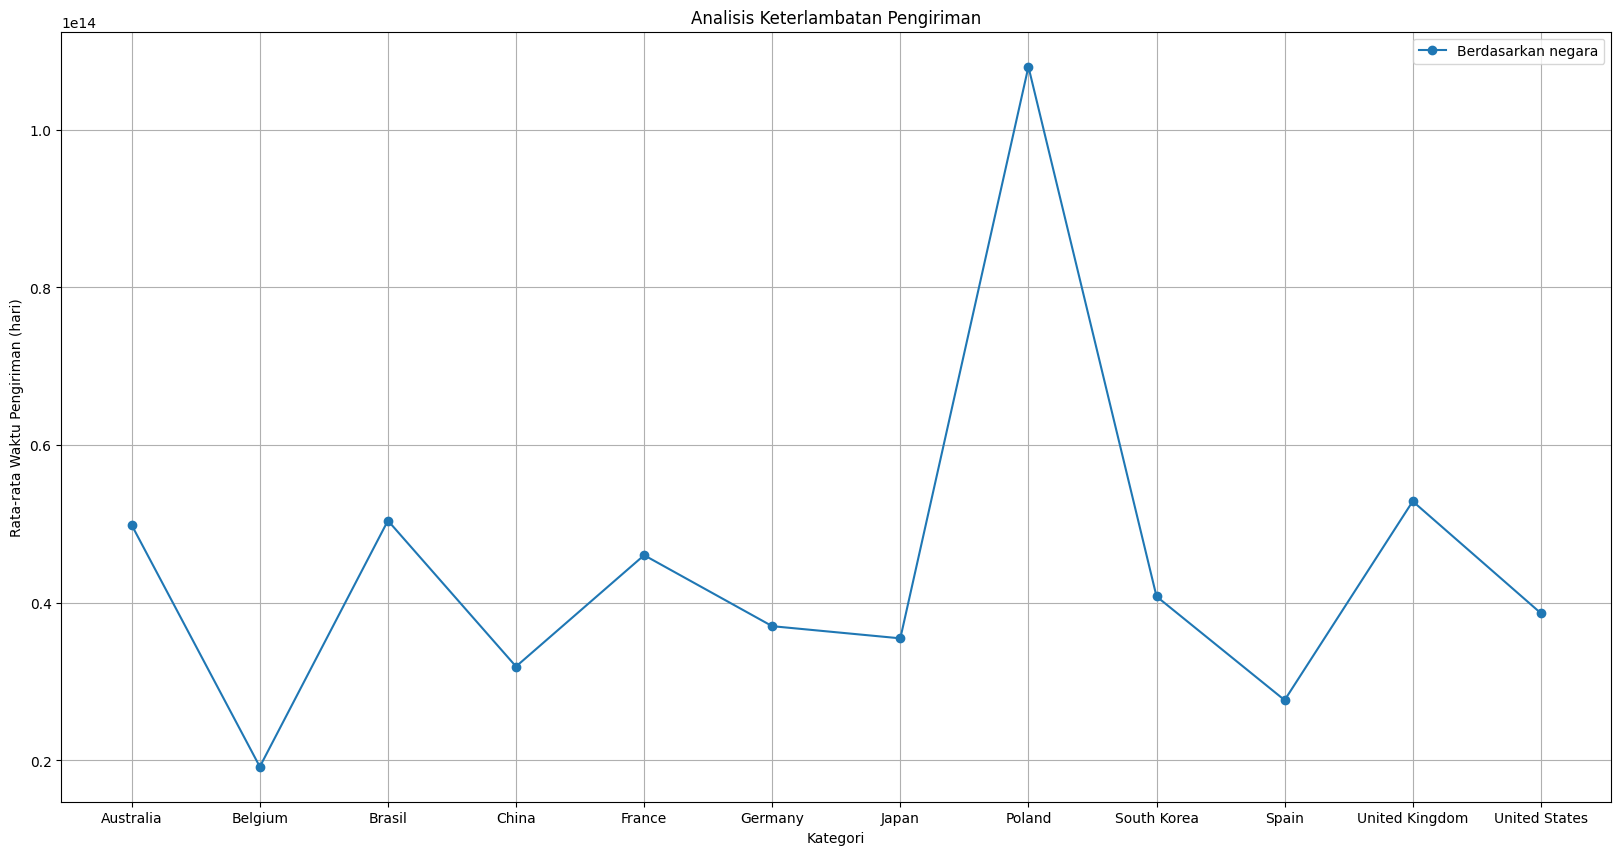

In [9]:
# 1. Analisis keterlambatan berdasarkan negara
a_avg_delivery_time = df.groupby('country')['delivery_time'].mean()

# Visualisasi hasil analisis
plt.figure(figsize=(20, 10))
plt.plot(a_avg_delivery_time.index, a_avg_delivery_time.values, marker='o', label='Berdasarkan negara')
plt.title('Analisis Keterlambatan Pengiriman')
plt.xlabel('Kategori')
plt.ylabel('Rata-rata Waktu Pengiriman (hari)')
plt.legend()
plt.grid(True)
plt.show()

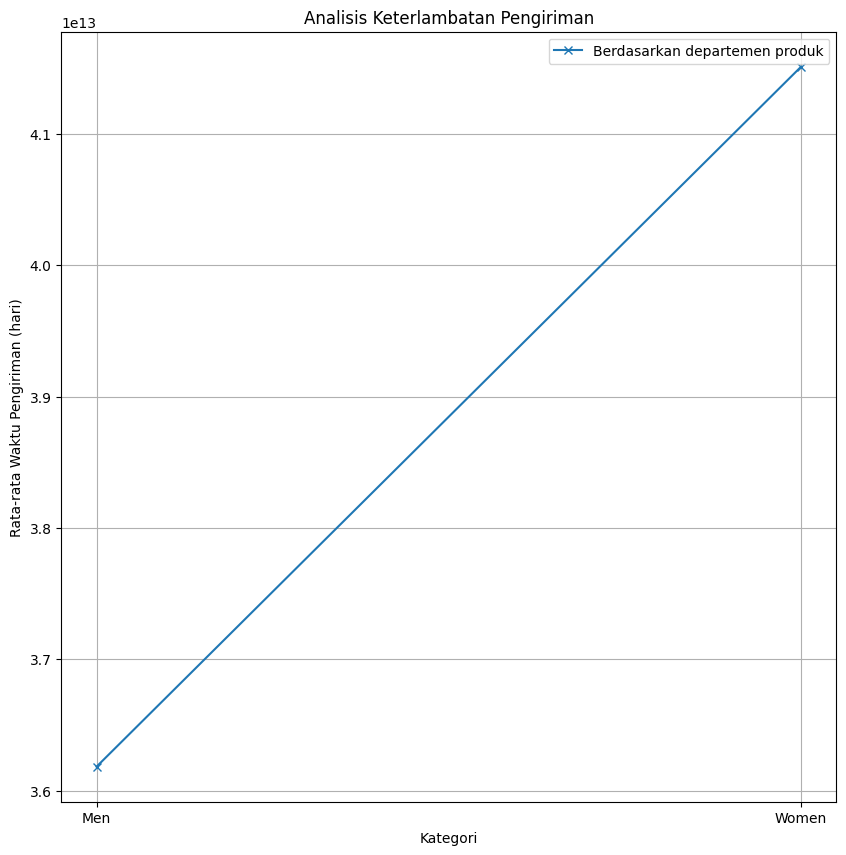

In [10]:
# 2. Analisis keterlambatan berdasarkan departemen produk
b_avg_delivery_time = df.groupby('product_department')['delivery_time'].mean()

# Visualisasi hasil analisis
plt.figure(figsize=(10, 10))
plt.plot(b_avg_delivery_time.index, b_avg_delivery_time.values, marker='x', label='Berdasarkan departemen produk')
plt.title('Analisis Keterlambatan Pengiriman')
plt.xlabel('Kategori')
plt.ylabel('Rata-rata Waktu Pengiriman (hari)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Filter data hanya untuk bulan Maret
data_march = df[df['month'] == 3]

# Hapus baris dengan nilai null pada kolom waktu pengiriman dan negara
data_march = data_march.dropna(subset=['delivery_time', 'country'])

# Buat daftar dari kelompok negara
countries = data_march['country'].unique()

# Buat daftar kelompok pengiriman waktu untuk setiap negara
delivery_time_groups = [data_march[data_march['country'] == country]['delivery_time'].dt.days for country in countries]

# Lakukan uji ANOVA
f_statistic, p_value = f_oneway(*delivery_time_groups)

# Nilai ambang batas (signifikansi)
alpha = 0.05

# Cetak hasil uji statistik
print("Hasil Uji ANOVA:")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpretasi hasil
if p_value < alpha:
    print("Terdapat perbedaan signifikan dalam keterlambatan pengiriman antara negara-negara.")
else:
    print("Tidak terdapat perbedaan signifikan dalam keterlambatan pengiriman antara negara-negara.")

Hasil Uji ANOVA:
F-statistic: 0.6416569484157272
P-value: 0.7930816290584378
Tidak terdapat perbedaan signifikan dalam keterlambatan pengiriman antara negara-negara.


Identifikasi Alasan Keterlambatan Pengiriman:

1. **Peningkatan Pesanan:** Salah satu faktor yang mungkin menyebabkan keterlambatan pengiriman adalah peningkatan pesanan dari pelanggan. Jika jumlah pesanan tiba-tiba meningkat secara signifikan, bisa menjadi penyebab keterlambatan karena meningkatnya volume pekerjaan yang perlu diproses.

2. **Keterlambatan dari Penyedia Pengiriman:** Masalah dengan penyedia pengiriman seperti gangguan logistik, masalah cuaca, atau ketidakmampuan mereka untuk menghadapi lonjakan permintaan dapat menjadi penyebab keterlambatan pengiriman.

3. **Gangguan pada Rute Pengiriman:** Keterlambatan pengiriman juga bisa terjadi karena gangguan pada rute pengiriman, seperti kecelakaan lalu lintas, jalan yang rusak, atau perubahan dalam jadwal pengiriman yang telah diatur.

Analisis lebih lanjut mungkin diperlukan untuk mengidentifikasi penyebab keterlambatan secara lebih mendalam. Ini bisa mencakup wawancara dengan staf terkait, pemeriksaan proses logistik, dan pemantauan secara rinci terhadap data pengiriman untuk mengidentifikasi pola atau tren tertentu yang berkontribusi pada keterlambatan.

## Problem 2

Analisis Kinerja Stok (Stock Performance Analysis):

* Perhitungan jumlah produk yang tersedia (stok) selama kuartal pertama hingga kuartal kedua 2023.
* Evaluasi perubahan stok dari waktu ke waktu dan hubungannya dengan tingkat penjualan. Apakah terdapat tren penjualan khusus yang berdampak pada stok?

In [12]:
# 1. Hitung Jumlah Stok
total_stock_in = df['inventory_in_date'].count()
total_stock_out = df['inventory_out_date'].count()
total_stock = total_stock_in - total_stock_out
print(f"Jumlah produk yang tersedia selama kuartal pertama hingga kuartal kedua 2023: {total_stock}")

Jumlah produk yang tersedia selama kuartal pertama hingga kuartal kedua 2023: 1851


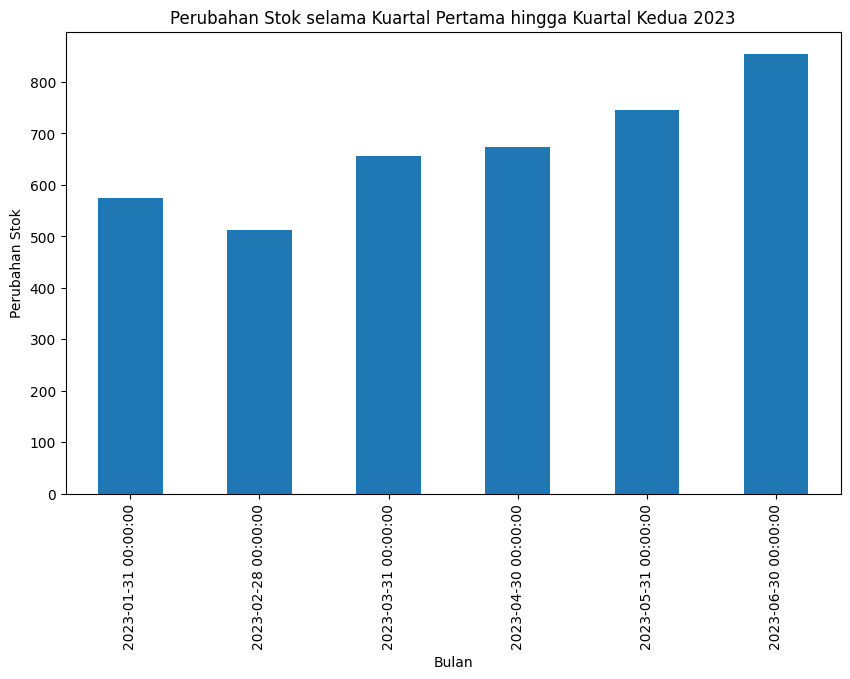

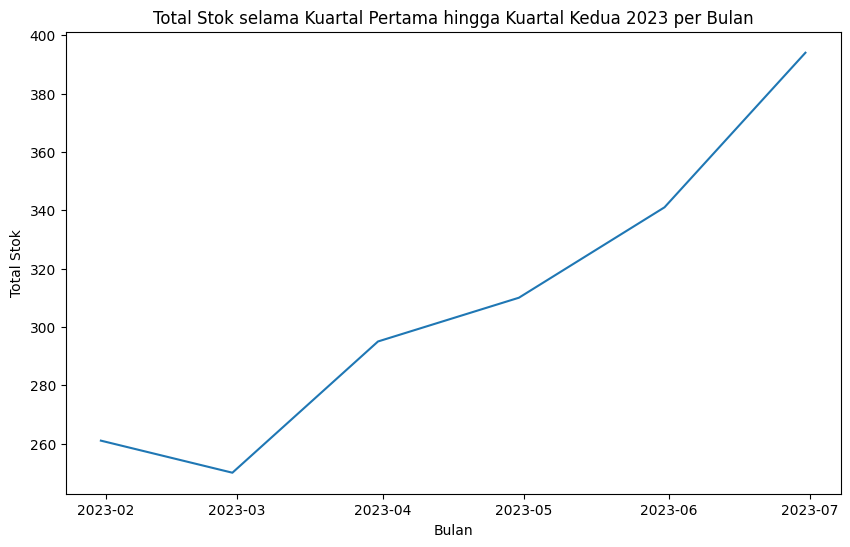

In [13]:
# 2. Analisis Perubahan Stok
stock_changes = df.groupby(pd.Grouper(key='ordering_date', freq='M'))['id'].count()

# Hitung total stok per bulan
total_stock_in_per_month = df.groupby(pd.Grouper(key='ordering_date', freq='M'))['inventory_in_date'].count()
total_stock_out_per_month = df.groupby(pd.Grouper(key='ordering_date', freq='M'))['inventory_out_date'].count()
total_stock_per_month = total_stock_in_per_month - total_stock_out_per_month

# Plot grafik bar untuk perubahan stok
stock_changes.plot(kind='bar', figsize=(10, 6))
plt.title('Perubahan Stok selama Kuartal Pertama hingga Kuartal Kedua 2023')
plt.xlabel('Bulan')
plt.ylabel('Perubahan Stok')
plt.show()

# Plot grafik garis untuk total stok per bulan
plt.figure(figsize=(10, 6))
sns.lineplot(x=total_stock_per_month.index, y=total_stock_per_month.values)
plt.title('Total Stok selama Kuartal Pertama hingga Kuartal Kedua 2023 per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Stok')
plt.show()

In [14]:
# 3. Hubungan dengan Penjualan

# Mengambil data penjualan
sales_data = df[['inventory_out_date', 'sale_price']]

# Mengelompokkan data penjualan berdasarkan bulan dan menghitung total penjualan per bulan
monthly_sales = sales_data.groupby(pd.Grouper(key='inventory_out_date', freq='M'))['sale_price'].sum()

# Menggabungkan data penjualan dan perubahan stok per bulan
monthly_data = pd.concat([stock_changes, monthly_sales], axis=1)
monthly_data.columns = ['Perubahan Stok', 'Total Penjualan']

# Menghitung korelasi Pearson antara perubahan stok dan penjualan
correlation = monthly_data['Perubahan Stok'].corr(monthly_data['Total Penjualan'])
print(f"Korelasi antara perubahan stok dan penjualan (sold_price) adalah: {correlation:.2f}")

Korelasi antara perubahan stok dan penjualan (sold_price) adalah: 0.68


Data yang diberikan menyediakan informasi yang berharga tentang kinerja stok dan penjualan perusahaan. Berikut adalah beberapa kesimpulan yang dapat diambil dari data tersebut:

1. **Jumlah Produk Tersedia:** Selama kuartal pertama hingga kuartal kedua 2023, perusahaan memiliki total 1851 produk yang tersedia. Ini adalah informasi penting untuk manajemen persediaan dan dapat membantu dalam perencanaan ke depan.

2. **Kenaikan Konsisten Stok:** Terdapat kenaikan yang konsisten dalam stok selama 5 bulan konsekutif. Hal ini menunjukkan pertumbuhan stok yang stabil dan dapat mengindikasikan potensi tren bisnis yang positif jika pertumbuhan ini berlanjut.

3. **Korelasi Positif antara Stok dan Penjualan:** Data menunjukkan adanya korelasi positif antara perubahan stok dan penjualan (sold_price). Ini berarti jika perubahan stok meningkat, penjualan juga meningkat, dan sebaliknya. Informasi ini sangat berguna dalam perencanaan persediaan dan strategi penjualan.

Dengan demikian, perusahaan dapat menggunakan informasi ini untuk mengoptimalkan manajemen persediaan, memahami tren bisnis yang mungkin terjadi, dan merencanakan strategi penjualan yang lebih efektif berdasarkan hubungan positif antara stok dan penjualan.

## Problem 3

Hubungan antara Pengiriman dan Stok:

* Pertimbangan apakah terdapat hubungan antara waktu pengiriman dan ketersediaan stok. Sebagai contoh, apakah keterlambatan pengiriman berkaitan dengan ketidakcukupan stok?

In [19]:
# Mengambil data terkait
df_filtered = df.dropna(subset=['delivery_time', 'inventory_in_date'])

# Mengonversi kolom delivery time dan inventory in date ke dalam tipe data datetime
df_filtered['delivery_time'] = pd.to_timedelta(df_filtered['delivery_time'])
df_filtered['inventory_in_date'] = pd.to_datetime(df_filtered['inventory_in_date'])

# Menghitung korelasi antara delivery time dan inventory in date
correlation = df_filtered['delivery_time'].dt.total_seconds().corr(df_filtered['inventory_in_date'].dt.dayofyear)
print(f"Korelasi antara waktu pengiriman dan ketersediaan stok: {correlation}")

Korelasi antara waktu pengiriman dan ketersediaan stok: 0.002164240758292888


Berdasarkan data yang ada, dapat disimpulkan bahwa tidak terdapat hubungan atau keterkaitan antara waktu pengiriman dan ketersediaan stok, sehingga tidak perlu memberikan perhatian lebih pada aspek ini.